In [1]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# sys.path.append('../src')
# import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

In [114]:
# use a consistent to make comparable to sklearn model
test_sfere_ids = pd.read_csv('/home/bp/data-analytics/notebooks/data/sfere_og_test_set.csv', low_memory=False)
print(f'test set has {test_sfere_ids.shape[0]} samples')
test_sfere_ids.head()

test set has 1153 samples


,sfere_id
0,28800
1,30479
2,28008
3,28682
4,31076


In [115]:
from fastai.text.all import *

In [116]:
path = Path('./data/')

In [117]:
files_dir = 'ds_lm_12m_icd_sfere'
files = get_text_files(path, folders = [files_dir])

len(files)

12881

### Modelling

In [118]:
files_dir = 'ds_lm_12m_icd_sfere'
files = get_text_files(path, folders = [files_dir])

len(files)

12881

In [119]:
models_path = '/home/bp/data-analytics/models/'
model_root_name = 'ds_icds_model_20221111'

In [120]:
vocab_path = '/home/bp/data-analytics/modelslml_epoch_20_vocab_20220922.pkl'
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [121]:
text_block = TextBlock.from_folder(
    path / files_dir, 
    vocab=vocab,
    is_lm=False,
    seq_len=72,
    backwards=False
)

In [122]:
def label_func(fname):
    match = re.match('\d*_\d*_(.*)\.txt$', fname.name)
    if match is not None:
        return float(match.groups()[0])
    else:
        print('failed on', fname.name)
        return int(match.groups()[0])
#     return float(re.match(r'^\d_\d*_(.*)\.txt$', fname.name).groups()[0])

In [123]:
dblocks = DataBlock(blocks=(text_block, RegressionBlock),
                 get_items=get_text_files,
                 get_y=label_func,
                 splitter=RandomSplitter())

In [124]:
dls = dblocks.dataloaders(path / 'ds_lm_12m_icd_sfere', bs=64)

In [125]:
dls.show_batch(max_n=3)

,text,text_
0,xxbos b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 z89512 ttlc_30 b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 z89512 ttlc_10 b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 z89512 ttlc_10 b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 g629 z89512 ttlc_60 b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 z89512 ttlc_10 b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 z89512 ttlc_10 b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 z89512 ttlc_15 b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 z89512 ttlc_5 b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 z89512 ttlc_5 b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 z89512 ttlc_15 b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 i10 z89512 ttlc_1 b1710 e109 f1020 f1120 f1210 xxunk xxrep xxunk xxunk f82 ttlc_1 b1710 e109 f1020 f1120,25.0
1,xxbos e119 e785 g311 i4891 m1990 r1310 r627 r6889 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891 m1990 r1310 r627 ttlc_1 e119 e785 g311 i4891,56.0
2,xxbos f0280 g20 g40909 i110 i4891 i509 n390 r5381 ttlc_5 f0280 g20 g40909 i110 i4891 i509 n390 r300 r350 r5381 ttlc_30 g20 g40909 i110 i4891 i509 n390 r5381 z466 ttlc_10 g20 g40909 i110 i4891 i509 n390 r5381 z466 ttlc_2 g20 g40909 i110 i4891 i509 n390 r5381 z466 ttlc_5 g20 g40909 i110 i4891 i509 n390 r5381 z466 ttlc_5 g20 g40909 i110 i4891 i509 n390 r5381 z466 ttlc_5 g20 g40909 i110 i4891 i509 n390 r5381 z466 ttlc_5 g20 g40909 i110 i4891 i509 n390 r5381 z466 ttlc_15 f319 g8220 i10 j449 m479 n390 r5381 z452 ttlc_5 f319 g8220 i10 j449 m479 n390 r5381 z452 ttlc_10 f319 g8220 i10 j449 m479 n390 r5381 z452 ttlc_1 f319 g8220 i10 i499 j449 m2450 m479 n390 r21 r5381 r609 z452 z993 ttlc_10 f319 g8220 i10 j449 m479 n390 r5381 z452 ttlc_10 e876 f319 g8220 i10 i499 j449 m2450 m479 m519 n390 r5381 z452 ttlc_5 f319 g8220 i10,56.0


In [126]:
learn = text_classifier_learner(
    dls,
    AWD_LSTM,
#     drop_mult=0.5,
    metrics=[mae],
    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=4)
).to_fp16()

learn = learn.load_encoder('/home/bp/data-analytics/modelslml_epoch_20_encoder_20220922')

In [127]:
learn.model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(10952, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(10952, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True

In [128]:
learn.freeze()

/home/bp/.local/share/virtualenvs/data-analytics-qWXImv-u/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0691830962896347)

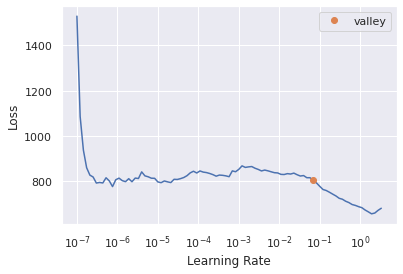

In [129]:
learn.lr_find()

In [130]:
learn.fit_one_cycle(5, 10e-3)

epoch,train_loss,valid_loss,mae,time
0,447.303223,272.426666,11.692067,00:29
1,239.186600,239.748978,11.084970,00:29
2,215.996613,234.788605,11.058614,00:29
3,193.488678,228.754120,11.020343,00:29
4,180.418030,229.137085,10.980090,00:29


In [131]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,mae,time
0,184.964645,228.383682,10.923099,00:29


epoch,train_loss,valid_loss,mae,time
0,183.250748,236.199432,11.422044,01:05
1,185.058029,230.773026,11.025460,01:05
2,168.229156,230.579803,11.186184,01:05
3,152.482483,225.336548,10.912498,01:05
4,143.311127,226.416031,10.991318,01:06


In [132]:
f = files[0]

'valid'

In [142]:
# need to move the test file back b/c of fastai path check
test_files = []
for f in files:
    if f.parts[-2] == 'valid':
        test_files.append(f)
#     match = re.match('\d*_(.*)_\d*\.txt$', f.name)
#     sfere_id = int(match.groups()[0])
#     if sfere_id in test_sfere_ids.sfere_id.values:
#     os.rename(f, f'data/ds_lm_12m_icd_sfere/{f.name}')

In [143]:
test_dl = learn.dls.test_dl(test_files)

In [144]:
r = learn.get_preds(dl=test_dl)

In [145]:
preds, _ = r
preds = preds.flatten().tolist()
# preds

In [146]:
len(test_files), len(preds)

(1106, 1106)

In [147]:
rows = []
for p, f in zip(preds, files):
    f.name
    match = re.match('\d*_(.*)_\d*\.txt$', f.name)
    rows.append((int(match.groups()[0]), p))

df = pd.DataFrame(rows, columns=['sfere_id', 'pred'])
df.head()

In [149]:
df.to_csv('./outputs/ds_hrs_lm_sfere_preds.csv', index=False)

### Try and get patient vectors

In [43]:
# TODO: Add some addl features ie age gender pre_impactable_spend and combine with encoded icds

In [157]:
learn.model[1]

PoolingLinearClassifier(
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): Linear(in_features=50, out_features=1, bias=False)
    )
  )
)

In [159]:
config = awd_lstm_lm_config.copy()
config

{'emb_sz': 400,
 'n_hid': 1152,
 'n_layers': 3,
 'pad_token': 1,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

In [174]:
learn.model = learn.model[0]
# [1].get_submodule('layers')
# [c for c in learn.model.children()]

In [185]:
for b in test_dl:
    print(b)
    break

(TensorText([[  2, 146, 465,  ..., 163,  12,  24],
        [  2, 119, 317,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:0'),)


In [191]:
b[0].shape

torch.Size([64, 3537])

In [197]:
b[0][0]

TensorText([  2, 146, 465,  ..., 163,  12,  24], device='cuda:0')

In [199]:
p = learn.model(b[0])

In [201]:
p[0].shape

torch.Size([64, 1377, 400])

In [204]:
def masked_max_pool(output, mask, bptt):
    return output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
r = masked_max_pool(p[0], p[1], None)
r

TensorText([[ 0.8836,  0.9973,  0.9230,  ...,  0.9945, -0.8946,  0.9447],
        [ 0.3784,  0.9992,  0.9986,  ...,  0.9920, -0.5852,  0.9875],
        [ 0.2520,  0.9956,  0.9047,  ...,  0.8931, -0.2326,  0.9911],
        ...,
        [ 0.8409,  0.9967,  0.9999,  ...,  0.9142, -0.0750,  0.8968],
        [ 0.9875,  0.9477,  0.9963,  ...,  0.9869,  0.9775,  0.8365],
        [ 0.9904,  0.9387,  1.0000,  ...,  0.9259,  0.8454,  0.6689]],
       device='cuda:0', grad_fn=<AliasBackward>)

In [205]:
r.shape

torch.Size([64, 400])

In [208]:
def masked_max_pool(output, mask, bptt):
    return output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]

def last_hdn_pool(output, mask, bptt):
    last_lens = mask[:,-bptt:].long().sum(dim=1)
    return output[torch.arange(0, output.size(0)),-last_lens-1]

def masked_avg_pool(output, mask, bptt):
    lens = output.shape[1] - mask.long().sum(dim=1)
    avg_pool = output.masked_fill(mask[:, :, None], 0).sum(dim=1)
    avg_pool.div_(lens.type(avg_pool.dtype)[:,None])
    return avg_pool

_pooler = {
    'concat': masked_concat_pool,
    'max': masked_max_pool,
    'last': last_hdn_pool,
    'avg': masked_avg_pool,
}

def get_sentence_encodings(learn, dl=None, method='max'):
    if dl is None:
        dl = learn.dls.valid
    learn.model.to(dl.device)
    learn.model.eval()
    sentence_encoder = learn.model
#     sentence_encoder = learn.model[0]
    bptt = getattr(sentence_encoder, 'bptt')
    encodings = []
    y = []
    pool = _pooler[method]
    pbar = progress_bar(dl)
    for b in pbar:
        xb = b[0]
        with torch.no_grad():
            enc, mask = sentence_encoder(xb)
        encodings.append(pool(enc, mask, bptt))
        if len(b)==2: y.append(b[1])
    if y:
        return torch.cat(encodings), torch.cat(y)
    else:
        return torch.cat(encodings), None

In [209]:
encodings = get_sentence_encodings(learn, test_dl, method='max')

In [213]:
encodings[0].shape

torch.Size([1106, 400])

In [218]:
rows = []
for p, f in zip(encodings[0], test_files):
    f.name
    match = re.match('\d*_(.*)_\d*\.txt$', f.name)
    rows.append((int(match.groups()[0]), p.tolist()))

df = pd.DataFrame(rows, columns=['sfere_id', 'encoding'])
df.head()

,sfere_id,encoding
0,29581,"[0.8835988640785217, 0.9973404407501221, 0.9230003356933594, 0.9132328033447266, 0.9837498664855957, 0.7293370366096497, 0.9370369911193848, 0.9514392018318176, 0.8978133797645569, 0.9928809404373169, 0.9834848046302795, 0.953713059425354, 0.9896664023399353, 0.9973999261856079, -0.07194118946790695, 0.9450374841690063, 0.7615752816200256, 0.9904870986938477, 0.8037583827972412, 0.9943156242370605, 0.9940720796585083, 0.989417314529419, 0.9500094652175903, 0.9966490268707275, 0.828056812286377, 0.25515642762184143, 0.9107691645622253, 0.9946683645248413, 0.9959135055541992, 0.8740137219429..."
1,30246,"[0.3783913552761078, 0.9992464780807495, 0.9985890984535217, 0.9930770397186279, 0.02186255156993866, 0.9901297092437744, 0.9082229137420654, 0.9673084020614624, 0.9985529780387878, 0.9831606149673462, 0.9944190382957458, 0.967221200466156, 0.998047947883606, 0.9978540539741516, 0.8389221429824829, 0.9017278552055359, 0.7639859318733215, 0.9962981939315796, 0.995924174785614, 0.9981665015220642, 0.9996671080589294, 0.994836151599884, 0.9868093132972717, 0.7239110469818115, 0.9861724972724915, 0.9989901185035706, 0.99885094165802, 0.9946638941764832, 0.8583559393882751, 0.9095064997673035, ..."
2,30670,"[0.252015084028244, 0.9955561757087708, 0.904729425907135, 0.9822694063186646, -0.13174910843372345, 0.9912676215171814, 0.7731713652610779, 0.8867921829223633, 0.8739010095596313, 0.9115517735481262, 0.9992135763168335, 0.819994330406189, 0.9877215027809143, 0.7854332327842712, 0.7505148649215698, 0.8042514324188232, 0.7611901164054871, 0.9664459824562073, 0.9780089259147644, 0.9840108156204224, 0.980398416519165, 0.9957728981971741, 0.8297146558761597, 0.9050136804580688, 0.9423801898956299, 0.9985165596008301, 0.9825594425201416, 0.9225603938102722, 0.9639935493469238, 0.818164110183715..."
3,29249,"[0.262898713350296, 0.9745723009109497, 0.9780696630477905, 0.9146320819854736, -0.7055046558380127, -0.6905450820922852, 0.7993090152740479, 0.9679160714149475, 0.9890725016593933, 0.9975789785385132, 0.9981364607810974, 0.9175068736076355, 0.9988387823104858, 0.9996628165245056, -0.10055335611104965, 0.9197019338607788, 0.6942135095596313, 0.9186991453170776, 0.5703691244125366, 0.9993622899055481, 0.9900875687599182, 0.9298713207244873, 0.9865602850914001, 0.7949761748313904, 0.9677327275276184, 0.9995937943458557, 0.9872386455535889, 0.9951695799827576, 0.9999866485595703, 0.9033841490..."
4,29553,"[0.9917703866958618, 0.9752515554428101, 0.9997694492340088, 0.942697286605835, -0.6068078875541687, 0.761864423751831, 0.8708745837211609, 0.9986209869384766, 0.9943908452987671, 0.9776286482810974, 0.9981840252876282, 0.9948448538780212, 0.9329229593276978, 0.9012890458106995, 0.38269251585006714, 0.8409509062767029, 0.7721584439277649, 0.9142084121704102, 0.9927392601966858, 0.9729107022285461, 0.9991215467453003, 0.9878517389297485, 0.8707382678985596, 0.999883234500885, 0.9611760973930359, 0.9647038578987122, 0.9519413709640503, 0.9944515824317932, 0.9901971220970154, 0.97000205516815..."


In [219]:
df.to_csv('./outputs/sfere_icd_encodings_20221116.csv', index=False)

### Visualize Results

In [ ]:
learn.model

In [ ]:
from torch.nn import functional as F

def get_normalized_embeddings():
    return F.normalize(learn.model[0].encoder.weight)

def most_similar(token, embs):
    if token[:2] == 'xx':
        return
#     idx = num.vocab.itos.index(token)
    idx = num.vocab.index(token)
    sims = (embs[idx] @ embs.t()).cpu().detach().numpy()

    print(f'Similar to: {token}: {icd_lookup[token]}')
    for sim_idx in np.argsort(sims)[::-1][1:11]:
        if num.vocab[sim_idx][:2] == 'xx':
            print(f'{sims[sim_idx]:.02f}: {num.vocab[sim_idx]}')
        else:
            print(f'{sims[sim_idx]:.02f}: {num.vocab[sim_idx]}: {icd_lookup[num.vocab[sim_idx]]}')
            

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random
import json


with open('icd_descr_lookup.json', 'r') as f:
    icd_lookup = json.load(f)

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
embeddings = get_normalized_embeddings()
most_similar('e11', embeddings)

In [ ]:
for code in random.sample(num.vocab, 10):
    most_similar(code, embeddings)
    print('')

In [ ]:
'xxfake'[:2]

In [ ]:
icd_lookup = icd_lookup[0]['jsonb_object_agg']

In [ ]:
icd_lookup['e11']

In [ ]:
with open('icd_descr_lookup.json', 'w') as f:
    json.dump(icd_lookup, f)